In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline

pd.set_option('max_columns', 8, 'max_rows', 10)

# Auctions Ventana 1

In [ ]:
# Leo el .csv, ordeno por fecha
auctions = pd.read_csv('data/auctions_ventanas/auctions_2019-04-18-2019-04-20.csv', low_memory=False, parse_dates=['date'])
auctions = auctions.sort_values(by='date')
auctions.head()

## Feature engineering

In [3]:
def is_easter_holiday(x):
    if x.day == 18 or x.day == 19 or x.day == 20 or x.day == 21:
        return 1
    else:
        return 0

In [2]:
def is_early_morning(x):
    if x.hour >= 3 and x.hour <= 7:
        return 1
    else:
        return 0

In [4]:
def is_late_evening(x):
    if x.hour >= 20:
        return 1
    else:
        return 0

In [ ]:
auctions['hour'] = auctions['date'].dt.hour.astype(np.int8)
auctions['early_morning'] = auctions['date'].map(is_early_morning).astype(np.int8)
auctions['late_evening'] = auctions['date'].map(is_late_evening).astype(np.int8)
auctions['weekday'] = auctions['date'].dt.weekday.astype(np.int8)
auctions['weekend'] = (auctions['weekday'] >= 5).astype(np.int8)
auctions['easter_holiday'] = auctions['date'].map(is_easter_holiday).astype(np.int8)
auctions['days_elapsed_since_window_start'] = (auctions['date'] - pd.Timestamp('2019-04-18 00:00:00')).astype('timedelta64[D]')
auctions['auction_number_since_window_start'] = np.arange(len(auctions))

## Cálculo de labels

In [ ]:
# device_id es ref_hash, me quedo con el primer registro (primera fecha) donde aparezca cada hash
auctions = auctions.rename(index=str, columns={'device_id' : 'ref_hash'})
auctions = auctions.drop_duplicates(subset='ref_hash')
auctions = auctions.set_index('ref_hash')
auctions

In [ ]:
# Ya tengo la fecha mínima para cada ref_hash, resto el momento inicial y convierto a segundos
auctions['date'] = auctions['date'] - pd.Timestamp('2019-04-18 00:00:00')
auctions['date'] = auctions['date'].map(lambda x: x.total_seconds())
auctions = auctions.rename(index=str, columns={'date' : 'time_first_ocurrence_since_window_start'})
auctions

## Entrenamiento y predicción del modelo

In [ ]:
features = auctions.drop('time_first_ocurrence_since_window_start', axis=1)
labels = auctions['time_first_ocurrence_since_window_start']
X_train, X_test, y_train, y_test = \
    train_test_split(features, labels, test_size=0.2, random_state=123)

In [ ]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

In [ ]:
y_pred = regressor.predict(X_test)

## Chequeo de resultados

In [ ]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred.flatten()})
df

In [ ]:
df1 = df.head(25)
df1.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R2 Score:', metrics.r2_score(y_test, y_pred))

# Generalización para cualquier ventana

In [5]:
def create_labels(time_window_df, start_date):
    # device_id es ref_hash, me quedo con el primer registro (primera fecha) donde aparezca cada hash
    time_window_df = time_window_df.rename(index=str, columns={'device_id' : 'ref_hash'})
    time_window_df = time_window_df.drop_duplicates(subset='ref_hash')
    time_window_df = time_window_df.set_index('ref_hash')
    
    # Ya tengo la fecha mínima para cada ref_hash, resto el momento inicial y convierto a segundos
    time_window_df['date'] = time_window_df['date'] - pd.Timestamp(start_date)
    time_window_df['date'] = time_window_df['date'].map(lambda x: x.total_seconds())
    time_window_df = time_window_df.rename(index=str, columns={'date' : 'time_first_ocurrence_since_window_start'})
    return time_window_df

In [6]:
def calculate_labels(filename, start_date):
    # Leo el .csv, ordeno por fecha
    auctions = pd.read_csv(filename, low_memory=False, parse_dates=['date'])
    auctions = auctions.sort_values(by='date')  
    return create_labels(auctions, start_date)

In [7]:
def add_features(time_window_df, start_date):
    time_window_df['hour'] = time_window_df['date'].dt.hour.astype(np.int8)
    time_window_df['early_morning'] = time_window_df['date'].map(is_early_morning).astype(np.int8)
    time_window_df['late_evening'] = time_window_df['date'].map(is_late_evening).astype(np.int8)
    time_window_df['weekday'] = time_window_df['date'].dt.weekday.astype(np.int8)
    time_window_df['weekend'] = (time_window_df['weekday'] >= 5).astype(np.int8)
    time_window_df['easter_holiday'] = time_window_df['date'].map(is_easter_holiday).astype(np.int8)
    time_window_df['days_elapsed_since_window_start'] = (time_window_df['date'] - pd.Timestamp(start_date)).astype('timedelta64[D]')
    time_window_df['auction_number_since_window_start'] = np.arange(len(time_window_df))

In [8]:
def process_time_window(filename, start_date):
    # Leo el .csv, ordeno por fecha
    auctions = pd.read_csv(filename, low_memory=False, parse_dates=['date'])
    auctions = auctions.sort_values(by='date')
    
    add_features(auctions, start_date)
    auctions = create_labels(auctions, start_date)
    return auctions

In [32]:
auctions1 = process_time_window('data/auctions_ventanas/auctions_2019-04-18-2019-04-20.csv', '2019-04-18 00:00:00')
auctions2 = process_time_window('data/auctions_ventanas/auctions_2019-04-20-2019-04-22.csv', '2019-04-20 00:00:00')
auctions3 = process_time_window('data/auctions_ventanas/auctions_2019-04-22-2019-04-24.csv', '2019-04-22 00:00:00')

In [33]:
auctions1 = auctions1.reset_index()
auctions1

,ref_hash,time_first_ocurrence_since_window_start,ref_type_id,source_id,...,weekend,easter_holiday,days_elapsed_since_window_start,auction_number_since_window_start
0,1826643666390887030,0.015050,7,0,...,0,1,0.0,0
1,7037174172278258682,0.029014,1,0,...,0,1,0.0,1
2,3392065368947589877,0.057540,1,1,...,0,1,0.0,2
3,1228982273563226229,0.126828,1,1,...,0,1,0.0,3
4,4123059034628125459,0.132510,1,8,...,0,1,0.0,4
...,...,...,...,...,...,...,...,...,...
318320,3249485961899571550,259196.265259,7,1,...,1,1,2.0,15644489
318321,6935058777451259898,259196.949571,1,1,...,1,1,2.0,15644543
318322,4775315369292092311,259197.827543,1,0,...,1,1,2.0,15644607
318323,587301283475662820,259198.834158,7,1,...,1,1,2.0,15644683


In [34]:
auctions2 = auctions2.reset_index()
auctions2

,ref_hash,time_first_ocurrence_since_window_start,ref_type_id,source_id,...,weekend,easter_holiday,days_elapsed_since_window_start,auction_number_since_window_start
0,4491705989956863407,0.005166,1,3,...,1,1,0.0,0
1,6073265998227243835,0.009549,7,1,...,1,1,0.0,1
2,6479567914167801229,0.010110,7,3,...,1,1,0.0,2
3,8920554029959209624,0.014031,1,1,...,1,1,0.0,3
4,3040575983818739617,0.044081,1,6,...,1,1,0.0,4
...,...,...,...,...,...,...,...,...,...
324617,947374661783990554,259194.910325,1,6,...,0,0,2.0,15654673
324618,1422534501860948637,259196.110749,1,7,...,0,0,2.0,15654791
324619,4412617977034496645,259196.852148,1,8,...,0,0,2.0,15654868
324620,1371129310990535320,259197.221121,1,0,...,0,0,2.0,15654900


In [35]:
auctions3 = auctions3.reset_index()
auctions3

,ref_hash,time_first_ocurrence_since_window_start,ref_type_id,source_id,...,weekend,easter_holiday,days_elapsed_since_window_start,auction_number_since_window_start
0,3258381879961405775,0.017842,1,0,...,0,0,0.0,0
1,4439408176817895343,0.061648,7,1,...,0,0,0.0,1
2,6979533046694728978,0.068298,1,1,...,0,0,0.0,2
3,5640959168804437141,0.068888,1,1,...,0,0,0.0,3
4,6570269971268216479,0.086176,1,1,...,0,0,0.0,4
...,...,...,...,...,...,...,...,...,...
325305,1415540518579505726,259197.062858,1,4,...,0,0,2.0,16157071
325306,6119751210537635400,259197.643413,7,2,...,0,0,2.0,16157104
325307,3975925616254662478,259198.269315,1,1,...,0,0,2.0,16157165
325308,4108397997066468606,259198.358554,7,0,...,0,0,2.0,16157172


In [36]:
auctions = auctions1.append(auctions2).append(auctions3)
auctions

,ref_hash,time_first_ocurrence_since_window_start,ref_type_id,source_id,...,weekend,easter_holiday,days_elapsed_since_window_start,auction_number_since_window_start
0,1826643666390887030,0.015050,7,0,...,0,1,0.0,0
1,7037174172278258682,0.029014,1,0,...,0,1,0.0,1
2,3392065368947589877,0.057540,1,1,...,0,1,0.0,2
3,1228982273563226229,0.126828,1,1,...,0,1,0.0,3
4,4123059034628125459,0.132510,1,8,...,0,1,0.0,4
...,...,...,...,...,...,...,...,...,...
325305,1415540518579505726,259197.062858,1,4,...,0,0,2.0,16157071
325306,6119751210537635400,259197.643413,7,2,...,0,0,2.0,16157104
325307,3975925616254662478,259198.269315,1,1,...,0,0,2.0,16157165
325308,4108397997066468606,259198.358554,7,0,...,0,0,2.0,16157172


In [37]:
auctions = auctions.drop_duplicates(subset='ref_hash')
auctions = auctions.set_index('ref_hash')
auctions

,time_first_ocurrence_since_window_start,ref_type_id,source_id,hour,...,weekend,easter_holiday,days_elapsed_since_window_start,auction_number_since_window_start
ref_hash,,,,,,,,,
1826643666390887030,0.015050,7,0,0,...,0,1,0.0,0
7037174172278258682,0.029014,1,0,0,...,0,1,0.0,1
3392065368947589877,0.057540,1,1,0,...,0,1,0.0,2
1228982273563226229,0.126828,1,1,0,...,0,1,0.0,3
4123059034628125459,0.132510,1,8,0,...,0,1,0.0,4
...,...,...,...,...,...,...,...,...,...
3591331482061878357,259184.678003,7,8,23,...,0,0,2.0,16155994
893188166373449652,259195.287317,1,0,23,...,0,0,2.0,16156923
1415540518579505726,259197.062858,1,4,23,...,0,0,2.0,16157071


In [38]:
auctions_test_window = calculate_labels('data/auctions_ventanas/auctions_2019-04-24-2019-04-26.csv', '2019-04-24 00:00:00')
auctions_test_window

,time_first_ocurrence_since_window_start,ref_type_id,source_id
ref_hash,,,
4962177571260097630,0.015206,1,1
6854070487213255676,0.016556,7,1
6028134205740110035,0.019373,1,1
8598596355049388965,0.043372,1,3
5420144902280053407,0.044957,1,1
...,...,...,...
1716969332272710057,259188.777881,7,0
3446833012758351091,259188.916098,7,1
5261424054779144196,259190.436946,1,2


In [39]:
labels1 = auctions['time_first_ocurrence_since_window_start']
labels2 = auctions_test_window['time_first_ocurrence_since_window_start']
merged = pd.merge(left=labels1, right=labels2, how='left', left_index=True, right_index=True)
merged['time_first_ocurrence_since_window_start_y'] = merged['time_first_ocurrence_since_window_start_y'].fillna(3*24*60*60)
merged

,time_first_ocurrence_since_window_start_x,time_first_ocurrence_since_window_start_y
ref_hash,,
1826643666390887030,0.015050,134311.515055
7037174172278258682,0.029014,2374.921186
3392065368947589877,0.057540,43041.217210
1228982273563226229,0.126828,1927.778678
4123059034628125459,0.132510,4277.054021
...,...,...
3591331482061878357,259184.678003,86384.678003
893188166373449652,259195.287317,86395.287317
1415540518579505726,259197.062858,86397.062858


In [40]:
merged.isnull().any()

time_first_ocurrence_since_window_start_x    False
time_first_ocurrence_since_window_start_y    False
dtype: bool

In [57]:
features = auctions
labels = merged['time_first_ocurrence_since_window_start_y']
X_train, X_test, y_train, y_test = \
    train_test_split(features, labels, test_size=0.7, random_state=123)
regressor = LinearRegression()
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

In [58]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred.flatten()})
df

,Actual,Predicted
ref_hash,,
1920012202444916834,259200.000000,101290.272473
76831604449706947,197425.302992,175523.128281
8454006279613666734,187500.794822,143995.657012
8431530686525257115,34607.270596,98848.720919
7449431502735159323,4993.089942,129859.221999
...,...,...
1888148939260211956,47279.519437,126992.707307
445697344066939370,259200.000000,200109.096990
2474358112522875230,58377.537201,131613.484923


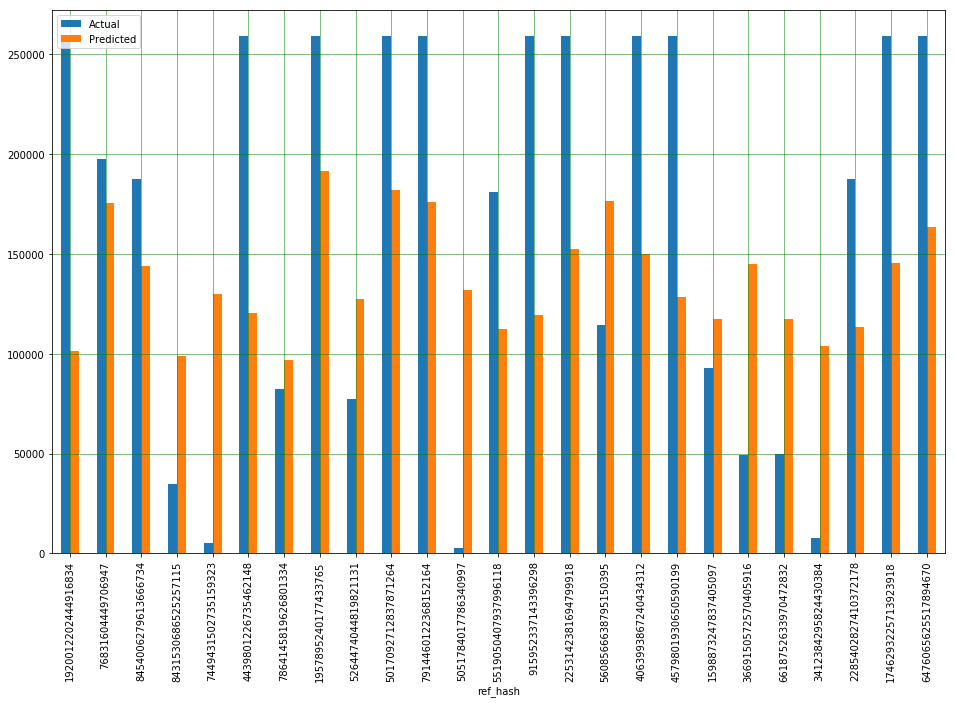

In [59]:
df1 = df.head(25)
df1.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [60]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R2 Score:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error: 94283.58693630219
Mean Squared Error: 10570194570.178242
Root Mean Squared Error: 102811.45155175196
R2 Score: 0.05307451133690866


## Exportar los resultados

In [61]:
target = pd.read_csv('data/target_competencia_ids.csv', low_memory=False)
target['ref_hash'] = target['ref_hash'].map(lambda x: x.split('_')[0]).astype(np.int64)
target = target.drop_duplicates(subset='ref_hash')
target

,ref_hash,obj
0,1000169251625791246,0
2,1000395625957344683,0
4,1003027494996471685,0
6,1006670001679961544,0
8,1007573308966476713,0
...,...,...
8064,977508757724050464,0
8066,979880031097032355,0
8068,987443249627191692,0
8070,997953354533822687,0


In [62]:
output = pd.Series(data = y_pred, index = X_test.index, name = 'pred')
output = output.reset_index()
output['ref_hash'] = output['ref_hash'].astype(np.int64)
output

,ref_hash,pred
0,1920012202444916834,101290.272473
1,76831604449706947,175523.128281
2,8454006279613666734,143995.657012
3,8431530686525257115,98848.720919
4,7449431502735159323,129859.221999
...,...,...
305489,1888148939260211956,126992.707307
305490,445697344066939370,200109.096990
305491,2474358112522875230,131613.484923
305492,8483030836668214224,165357.488277


In [63]:
output = output.merge(target, on='ref_hash', how='right')
output = output.fillna(output['pred'].mean())
output.to_csv("auctions_linear.csv", columns=['ref_hash', 'pred'], index=False)
output

,ref_hash,pred,obj
0,4439801226735462148,120272.269521,0
1,6476065625517894670,163337.559174,0
2,8782578056514097026,101172.996529,0
3,7555977993872852496,120265.290767,0
4,6614045601226075900,132103.835621,0
...,...,...,...
4032,956704247780926402,130927.255058,0
4033,97694307709005918,130927.255058,0
4034,977508757724050464,130927.255058,0
4035,979880031097032355,130927.255058,0


In [64]:
output['pred'].value_counts()

130927.255058    1491
107839.993874       1
182589.609073       1
103678.557391       1
179484.479868       1
                 ... 
132748.331285       1
134893.497531       1
105310.880436       1
113086.830711       1
143337.663733       1
Name: pred, Length: 2547, dtype: int64